# Librerias

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

In [28]:
!pip3 install --upgrade wandb

### Sublibrerias de tensorflow -keras-

In [29]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import regularizers

### Abrimos wandb

In [30]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### Hiper-parametros

In [31]:
lr = 0.005 #Learning rate
epochs = 8
bs = 120 #batch size
loss = "categorical_crossentropy"

### inicialización de wandb

In [32]:
run = wandb.init(
    # set the wandb project where this run will be logged
    name = "Prueba con más capas",
    project = "Deeplearning_Digit_Recognition",

    # track hyperparameters and run metadata with wandb.config
    config = {
        "layer_1": 512,
        "activation_1": "relu",
        "activation_2": "relu",
        "w_initializer": "RandomNormal",
        "optimizer": "RMSprop",
        "loss": loss,
        "metric": "accuracy",
        "epoch": epochs,
        "batch_size": bs,
        "layer_quantity": 2
    }
)

### Carga de datos

In [33]:
dataset=mnist.load_data()

### Datos de entrenamiento y prueba

In [34]:
(x_train, y_train), (x_test, y_test) = dataset

### Verificamos la forma de los datos

In [35]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


### Se aplanan las imagenes y se normalizan

In [36]:
entrada = int(x_train.shape[1]*x_train.shape[2])
stddev = 1/np.sqrt(entrada)
stddev2 = 1/np.sqrt(512)

x_train = x_train.reshape(int(x_train.shape[0]), entrada)
x_test = x_test.reshape(int(x_test.shape[0]), entrada)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

### Se aplica one-hot encoding sobre las categorias

In [37]:
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Creación de la red neuronal

In [38]:
model_ml = keras.Sequential(
    [
        layers.Dense(512, activation = "relu", name = "layer1", 
                     kernel_initializer=initializers.RandomNormal(stddev = stddev)),
        
        layers.Dense(512, activation = "relu", name = "layer2", 
                     kernel_initializer=initializers.RandomNormal(stddev = stddev2)),
        
        layers.Dense(num_classes, activation = "softmax", name = "output"),
    ]
) #Arquitectura de la red neuronal

model_ml.build(input_shape=(None, entrada))
model_ml.compile(loss = loss, optimizer = RMSprop(learning_rate = lr),metrics = ["accuracy"]) #Función de costo
model_ml.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

### Reinicio de la red neuronal si se necesita

In [39]:
for layer in model_ml.layers:
   if hasattr(layer, 'kernel_initializer'):
       new_weights = layer.kernel_initializer(layer.kernel.shape)
       layer.kernel.assign(new_weights)
   if hasattr(layer, 'bias_initializer') and layer.bias is not None:
       new_bias = layer.bias_initializer(layer.bias.shape)
       layer.bias.assign(new_bias)

### Estructura de la red neuronal

In [40]:
history = model_ml.fit(x_train, y_train,
                    batch_size = bs,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[
                        WandbMetricsLogger(log_freq=5),
                        WandbModelCheckpoint("models/model_ml.keras")
                    ])
run.finish()

Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9176 - loss: 0.2987 - val_accuracy: 0.9535 - val_loss: 0.1542
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9674 - loss: 0.1146 - val_accuracy: 0.9695 - val_loss: 0.1178
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9753 - loss: 0.0885 - val_accuracy: 0.9737 - val_loss: 0.0950
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9796 - loss: 0.0771 - val_accuracy: 0.9740 - val_loss: 0.1268
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9827 - loss: 0.0662 - val_accuracy: 0.9721 - val_loss: 0.1358
Epoch 6/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9846 - loss: 0.0590 - val_accuracy: 0.9758 - val_loss: 0.1259
Epoch 7/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9863 - loss: 0.0559 - val_accuracy: 0.9705 - val_loss: 0.1793
Epoch 8/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9890 - loss: 0.0471 - val_accuracy: 0.9740 - v

batch/accuracy,▁▂▃▄▄▆▇▇▇███████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▇▇▇███
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁
epoch/val_accuracy,▁▆▇▇▇█▆▇
epoch/val_loss,▅▂▁▃▄▃▆█
batch/accuracy,0.98905


In [41]:
score = model_ml.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.2047
Test loss: 0.204685777425766
Test accuracy: 0.9739999771118164


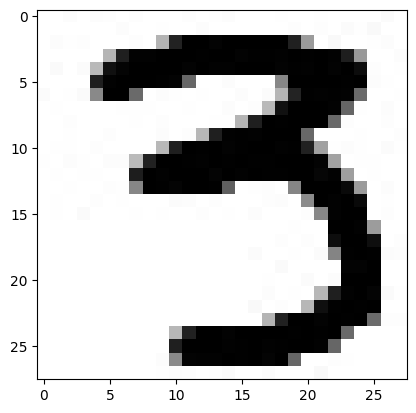

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(1, 10)
[4.0530785e-15 1.3128059e-12 5.8499499e-12 9.9999022e-01 1.0307981e-13
 9.7196034e-06 1.9053794e-16 1.4066584e-11 7.4273414e-09 9.7984829e-09]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [42]:
os.chdir(r"/tf/keras_neural_network/Mis_Tests")

mi_imagen = "Mitres.jpg"
imtest = imread(mi_imagen)
plt.imshow(imtest)
plt.show()

if imtest.ndim == 3:
    imtest = np.dot(imtest[...,:3], [0.2125, 0.7174, 0.0721])
imtest = np.where(imtest < 0.5, 1.0, 0.0)
imtest = imtest.reshape(1, 784).astype("float32")

a = model_ml.predict(imtest)
print(a.shape)
print(a[0])
print(np.where(a[0] == np.amax(a[0]),1.,0.))

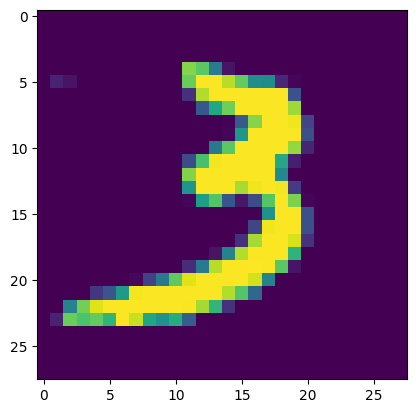

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)
[5.91911247e-31 1.10559913e-23 8.23001997e-22 1.00000000e+00
 1.15180356e-26 4.64104986e-19 1.47072813e-30 3.17658699e-23
 9.75099428e-25 3.24259485e-20]
resultado correcto:
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [43]:
os.chdir(r"/tf/keras_neural_network")
h = 7024 #h = 1 : número 2
         #h = 7018 : número 5
         #h = 7024 : número 3

plt.imshow(x_test[h].reshape(28,28))
plt.show()
a=model_ml.predict(x_test)

print(a.shape)
print(a[h])

print("resultado correcto:")
print(y_test[h])

In [44]:
#Para guardar el modelo en disco
model_ml.save("redmascapas.keras")